In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


#### Data_preparetion

In [4]:
df_all = pd.read_csv('../data/prediction_data_p1.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df_all['nor_package'] = 0
df_all.head()


,AA_sequence,nor_package
0,GANTIIG,0
1,SWDMDGD,0
2,LVSSSNI,0
3,WMGDESK,0
4,DKQGAKF,0


#### AA-sequence-nor_package

In [7]:
aa_nor_package = df_all[['AA_sequence', 'nor_package']][:500]
aa_nor_package = aa_nor_package.sort_values(by='nor_package')
(data_list, train_df, test_df, prepped_df) = prep_data(aa_nor_package,AA_colname = 'AA_sequence', target_assay_col="nor_package")
prepped_df['Y--nor_package'] = aa_nor_package['AA_sequence'].map(aa_nor_package.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
prepared_df =  prepped_df.drop(columns=['test','AA_sequence','Y--nor_package'])
AA_sequence = prepped_df['AA_sequence'] 
array = 'AA_sequence'

In [8]:
prepared_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


##### First model(1st_aa_nor_package) 

In [26]:
model_outdir = 'pretrain\model_1st_aa_nor_package'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
prediction_data = predict(model, prepared_df ,array,Y=None,AA=AA_sequence)
prediction_data = prediction_data.drop(columns=['z0','z1']) 
prediction_data.to_csv('../results/vae/1st_results/pred/1st_vae_aa_nor_package_prediction.csv')


16/16 [==============================] - 0s 2ms/step


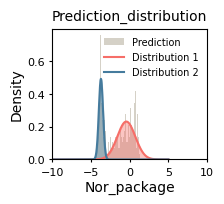

In [31]:
nor_package = prediction_data['y_pred']
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-10,-5,0,5,10]); 
ax.set_xlim([-10,10])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('../results/vae/1st_results/pred/1st_vae_aa_nor_package_prediction_distribution.pdf',dpi=300,bbox_inches='tight')
plt.show()

##### Second model(2nd_aa_nor_package) 

In [19]:
model_outdir = 'pretrain\\model_2nd_aa_nor_package'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
prediction_data = predict(model, prepared_df ,array,Y=None,AA=AA_sequence)
prediction_data = prediction_data.drop(columns=['z0','z1']) 
prediction_data.to_csv('../results/vae/2nd_results/pred/2nd_vae_aa_nor_package_prediction.csv')



16/16 [==============================] - 0s 968us/step


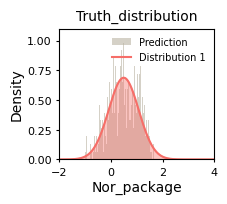

In [25]:
nor_package = prediction_data['y_pred']
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-2,0,2,4]); 
ax.set_xlim([-2,4])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('../results/vae/2nd_results/pred/2nd_vae_aa_nor_package_prediction_distribution.pdf',dpi=300,bbox_inches='tight')
plt.show()

#### aa-nor_transduction

##### First model(1st_seq_nor_transduction) 

In [34]:
model_outdir = 'pretrain\model_1st_aa_transduction'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
prediction_data = predict(model, prepared_df ,array,Y=None,AA=AA_sequence)
prediction_data = prediction_data.drop(columns=['z0','z1']) 
prediction_data.to_csv('../results/vae/1st_results/pred/1st_vae_aa_nor_transduction_prediction.csv')

16/16 [==============================] - 0s 2ms/step


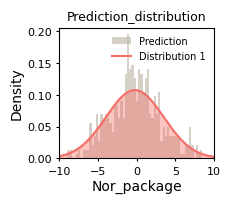

In [39]:
nor_package = prediction_data['y_pred']
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 10, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction_distribution',fontsize=9)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-10,-5,0,5,10]); 
ax.set_xlim([-10,10])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('../results/vae/1st_results/pred/1st_vae_aa_transduction_prediction_distribution.pdf',dpi=300,bbox_inches='tight')
plt.show()

##### Second model(2nd_aa_nor_transduction) 

In [40]:
model_outdir = 'pretrain\model_2nd_aa_transduction'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
prediction_data = predict(model, prepared_df ,array,Y=None,AA=AA_sequence)
prediction_data = prediction_data.drop(columns=['z0','z1']) 
prediction_data.to_csv('../results/vae/2nd_results/pred/2nd_vae_aa_nor_transduction_prediction.csv')

16/16 [==============================] - 0s 2ms/step


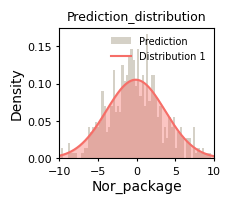

In [41]:
nor_package = prediction_data['y_pred']
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 10, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction_distribution',fontsize=9)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-10,-5,0,5,10]); 
ax.set_xlim([-10,10])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('../results/vae/2nd_results/pred/2nd_vae_aa_transduction_prediction_distribution.pdf',dpi=300,bbox_inches='tight')
plt.show()